🔧 **Setup Required**: Before running this notebook, please follow the [setup instructions](../../README.md#setup-instructions) to configure your environment and API keys.

# Building a Graph-based Agent with Tools using LangGraph

## Overview
This notebook demonstrates how to create an **agent** that uses external tools to answer questions, running entirely locally with Ollama and Mistral-Nemo.

## What You'll Learn
1. How to set up a local LLM agent with Ollama
2. How to integrate search tools (Tavily) with an agent
3. How to build an agent loop that decides when to use tools
4. How to manage state across multiple agent steps

## Requirements
- **Ollama** installed with Mistral-Nemo model: `ollama pull mistral-nemo:12b`
- **Tavily API key** for search functionality (get free key at [tavily.com](https://tavily.com))

## Benefits
- 🔒 **Privacy**: LLM runs completely locally
- 💰 **Cost-effective**: No API costs for the language model
- ⚡ **Fast**: Mistral-Nemo is optimized for speed and quality

## Step 1: Verify Ollama Setup

Let's check that Ollama is running and the Mistral-Nemo model is available.

In [2]:
import subprocess

try:
    result = subprocess.run(['ollama', 'list'], capture_output=True, text=True, timeout=5)
    if result.returncode == 0:
        print("✓ Ollama is installed and running\n")
        print("Available models:")
        print(result.stdout)
        
        if 'mistral-nemo' in result.stdout.lower():
            print("\n✓ Mistral-Nemo model is ready!")
        else:
            print("\n⚠️  Run: ollama pull mistral-nemo:12b")
    else:
        print("⚠️  Ollama might not be running. Try: ollama serve")
except FileNotFoundError:
    print("❌ Ollama not found. Install from: https://ollama.com")
except Exception as e:
    print(f"⚠️  Error: {e}")

✓ Ollama is installed and running

Available models:
NAME                       ID              SIZE      MODIFIED     
nomic-embed-text:latest    0a109f422b47    274 MB    3 days ago      
mistral-nemo:12b           e7e06d107c6c    7.1 GB    3 days ago      
qwen2:0.5b                 6f48b936a09f    352 MB    2 weeks ago     
gpt-oss:20b                f2b8351c629c    13 GB     3 months ago    


✓ Mistral-Nemo model is ready!


## Step 2: Import Libraries

We'll import:
- **LangGraph**: For building the agent workflow
- **ChatOllama**: For local LLM integration  
- **TavilySearchResults**: For web search capabilities

In [3]:
import os
from typing import Annotated, Literal
from operator import add

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI  # Alternative for faster performance
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv

# Load environment variables (for Tavily API key)
load_dotenv()

print("✓ Libraries imported successfully")

/Users/laurafunderburk/Documents/GitHub/Building-Natural-Language-Pipelines/ch2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Libraries imported successfully


## Step 3: Define Agent State

The state tracks:
- **messages**: Conversation history (inherited from `MessagesState`)
- **tool_calls_count**: Number of times tools have been used

In [4]:
class AgentState(MessagesState):
    """State for our agent that tracks conversation and tool usage."""
    tool_calls_count: Annotated[int, add]

print("✓ Agent state defined")

✓ Agent state defined


## Step 4: Set Up Tools and Model

We configure:
- **Tavily search tool**: Returns top 3 search results
- **Mistral-Nemo model**: A 12B parameter model optimized for tool use
- **Tool binding**: Connects the tools to the model

### ⚠️ Performance Note

**Running Time**: Using Ollama with local models will be **slower** than cloud-based APIs, especially on CPU. The Mistral-Nemo 12B model may take several seconds per response.

**For Faster Performance**: If you need quicker responses and don't mind using a cloud API:
- Use **ChatOpenAI** instead (requires OpenAI API key)
- Responses will be significantly faster but will incur API costs
- The code for ChatOpenAI alternative is included below as commented code

In [5]:
# Initialize search tool
tools = [TavilySearchResults(max_results=3)]

# Initialize local LLM with Ollama (slower but private and free)
llm = ChatOllama(
    model="mistral-nemo:12b",
    temperature=0,
)

# # Alternative: Use ChatOpenAI for faster performance (requires API key)
# # Uncomment the lines below and comment out ChatOllama above to use OpenAI
# llm = ChatOpenAI(
#     model="gpt-4o-mini",  # or "gpt-4" for better quality
#     temperature=0,
# )

# Bind tools to the model
llm_with_tools = llm.bind_tools(tools)

print("✓ Mistral-Nemo model initialized with tools")
print(f"✓ Available tools: {[tool.name for tool in tools]}")

✓ Mistral-Nemo model initialized with tools
✓ Available tools: ['tavily_search_results_json']


/var/folders/k7/8m84jpf52x7gvx628v82h2p80000gn/T/ipykernel_29858/4026440701.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tools = [TavilySearchResults(max_results=3)]


## Step 5: Define Agent Node

The agent node is where the LLM:
1. Receives the conversation history
2. Decides whether to use a tool or respond directly
3. Returns its decision (which may include tool calls)

In [6]:
def agent_node(state: AgentState):
    """The agent decides whether to use tools or respond directly."""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

print("✓ Agent node defined")

✓ Agent node defined


## Step 6: Define Routing Logic

This function determines the next step:
- If the agent wants to use tools → route to "tools"
- If the agent has finished → route to END

In [7]:
def should_continue(state: AgentState) -> Literal["tools", "__end__"]:
    """Determine if we should continue to tools or end."""
    last_message = state["messages"][-1]
    
    # Check if the agent wants to use tools
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return "__end__"

print("✓ Routing logic defined")

✓ Routing logic defined


## Step 7: Build the Agent Graph

The graph structure:
```
START → agent → [decision]
                ├→ tools → agent (loop back)
                └→ END
```

This creates a loop where:
1. Agent analyzes the question
2. If needed, calls tools for information
3. Processes tool results
4. Repeats until ready to answer
5. Returns final response

In [8]:
# Build the workflow
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("tools", ToolNode(tools))

# Define the flow
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"tools": "tools", "__end__": END}
)
workflow.add_edge("tools", "agent")

# Compile the graph
app = workflow.compile()

print("✓ Agent graph compiled successfully!")

✓ Agent graph compiled successfully!


## Step 8: Visualize the Graph

Let's see the structure of our agent workflow.

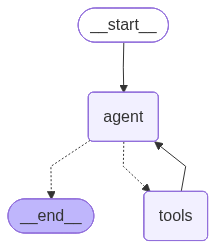

In [9]:
# Display the graph
app

## Step 9: Test the Agent

Let's test with a query that requires current information (will trigger tool use).

In [10]:
query = "What are the latest developments in AI language models in 2025?"

print(f"🔍 Query: {query}")


# Run the agent
result = app.invoke({
    "messages": [("user", query)],
    "tool_calls_count": 0
})

# Display the response
print("=" * 80)
print("AGENT RESPONSE:")
print("=" * 80)
print(result["messages"][-1].content)
print("\n" + "=" * 80)
print(f"📊 Total messages: {len(result['messages'])}")
print(f"🔧 Tool used: {len(result['messages']) > 2}")

🔍 Query: What are the latest developments in AI language models in 2025?
AGENT RESPONSE:
Here are some of the latest developments in AI language models as of November 2025:

1. **Top Large Language Models:**
   - Grok 4 and Grok 4 Heavy from xAI lead the pack, demonstrating enhanced reasoning capabilities refined through large-scale reinforcement learning. These models can handle complex tasks and make decisive plans due to their native tool use and real-time search features, making them "agentic." (Source: [Top 9 Large Language Models as of November 2025 | Shakudo](https://www.shakudo.io/blog/top-9-large-language-models))

2. **Global AI Model Development:**
   - In 2024, U.S.-based institutions produced 40 notable AI models, while China produced 15 and Europe produced three. Although the U.S. maintains its lead in quantity, Chinese models have closed the quality gap significantly. (Source: [The 2025 AI Index Report | Stanford HAI](https://hai.stanford.edu/ai-index/2025-ai-index-repor

## Step 10: View Conversation Trace

Let's examine how the agent processed the request step-by-step.

In [10]:
print("\nFULL CONVERSATION TRACE:")
print("=" * 80 + "\n")

for i, msg in enumerate(result["messages"], 1):
    msg_type = type(msg).__name__
    print(f"Message {i} ({msg_type}):")
    print("-" * 40)
    
    if hasattr(msg, 'content') and msg.content:
        content = str(msg.content)
        print(f"Content: {content[:200]}..." if len(content) > 200 else f"Content: {content}")
    
    if hasattr(msg, 'tool_calls') and msg.tool_calls:
        print(f"Tool Calls: {len(msg.tool_calls)} tool(s) requested")
    
    print()


FULL CONVERSATION TRACE:

Message 1 (HumanMessage):
----------------------------------------
Content: What are the latest developments in AI language models in 2025?

Message 2 (AIMessage):
----------------------------------------
Tool Calls: 1 tool(s) requested

Message 3 (ToolMessage):
----------------------------------------
Content: [{"title": "Top 9 Large Language Models as of November 2025 | Shakudo", "url": "https://www.shakudo.io/blog/top-9-large-language-models", "content": "Alibaba has been actively advancing its language m...

Message 4 (AIMessage):
----------------------------------------
Content: As of 2025, several significant developments in AI language models have emerged:

1. **Hybrid Mixture-of-Experts Models**: Alibaba has introduced the Qwen3 series, which includes models like Qwen3-235...



## Step 11: Test Different Query Types

Let's see how the agent handles different types of questions:
- Questions requiring search (should use tools)
- Simple questions (should answer directly)

In [12]:
result = app.invoke({
        "messages": [("user", "What is 2 + 2?")],
        "tool_calls_count": 0
    })

# Display the response
print("=" * 80)
print("AGENT RESPONSE:")
print("=" * 80)
print(result["messages"][-1].content)
print("\n" + "=" * 80)
print(f"📊 Total messages: {len(result['messages'])}")
print(f"🔧 Tool used: {len(result['messages']) > 2}")

AGENT RESPONSE:
2 + 2 equals 4.

📊 Total messages: 2
🔧 Tool used: False


In [13]:
result = app.invoke({
        "messages": [("user","Who won the latest Nobel Prize in Physics?")],
        "tool_calls_count": 0
    })

# Display the response
print("=" * 80)
print("AGENT RESPONSE:")
print("=" * 80)
print(result["messages"][-1].content)
print("\n" + "=" * 80)
print(f"📊 Total messages: {len(result['messages'])}")
print(f"🔧 Tool used: {len(result['messages']) > 2}")

AGENT RESPONSE:
The 2023 Nobel Prize in Physics was awarded to:

- **Pierre Agostini** (The Ohio State University, USA)
- **Ferenc Krausz** (Max Planck Institute of Quantum Optics, Germany)
- **Anne L’Huillier** (Lund University, Sweden)

They were recognized for their experimental methods that generate attosecond pulses of light, which are used to study electron dynamics in matter. 

For more details, you can visit the official [Nobel Prize press release](https://www.nobelprize.org/prizes/physics/2023/press-release/).

📊 Total messages: 4
🔧 Tool used: True


## Step 12: Stream Agent Execution (Optional)

For long-running queries, we can stream the agent's execution to see each step in real-time.

In [14]:
query = "What are the top 3 tech companies by market cap right now?"

print(f"🔍 Query: {query}\n")
print("Streaming execution...\n")
print("=" * 80)

for event in app.stream({
    "messages": [("user", query)],
    "tool_calls_count": 0
}):
    for node_name, value in event.items():
        print(f"\n[Step: {node_name}]")
        if "messages" in value:
            last_msg = value["messages"][-1]
            msg_type = type(last_msg).__name__
            print(f"Type: {msg_type}")
            
            if hasattr(last_msg, 'content') and last_msg.content:
                content = str(last_msg.content)
                preview = content[:150] + "..." if len(content) > 150 else content
                print(f"Preview: {preview}")
        print("-" * 40)

🔍 Query: What are the top 3 tech companies by market cap right now?

Streaming execution...


[Step: agent]
Type: AIMessage
----------------------------------------

[Step: agent]
Type: AIMessage
----------------------------------------

[Step: tools]
Type: ToolMessage
Preview: [{"title": "The Largest Technology Companies by Market Cap in November ...", "url": "https://www.fool.com/research/largest-tech-companies/", "content"...
----------------------------------------

[Step: tools]
Type: ToolMessage
Preview: [{"title": "The Largest Technology Companies by Market Cap in November ...", "url": "https://www.fool.com/research/largest-tech-companies/", "content"...
----------------------------------------

[Step: agent]
Type: AIMessage
Preview: As of October 2023, the top three tech companies by market capitalization are:

1. **Nvidia (NASDAQ: NVDA)** - Market Cap: $4.8 trillion
2. **Apple (N...
----------------------------------------

[Step: agent]
Type: AIMessage
Preview: As of October 

## Understanding Agent Behavior

### When Does the Agent Use Tools?
- **Current information**: Weather, news, recent events
- **Factual verification**: When uncertain about facts
- **Real-time data**: Stock prices, sports scores

### When Does the Agent Answer Directly?
- **General knowledge**: Math, science, history
- **Reasoning tasks**: Logic problems, explanations
- **Creative tasks**: Writing, brainstorming

### The Agent Loop
```
User Question → Agent Analyzes → Need Info?
                                    ↓ Yes
Final Answer ← Agent Synthesizes ← Tools Execute
      ↓ No
     END
```

## Key Takeaways

### What We Built
✅ **Local agent**: Runs entirely on your machine with Ollama  
✅ **Tool integration**: Agent can search the web when needed  
✅ **Smart routing**: Decides when to use tools vs. answer directly  
✅ **State management**: Tracks conversation across multiple steps  

### Benefits
- 🔒 **Privacy**: No data sent to external LLM APIs
- 💰 **Cost-effective**: Free LLM inference
- ⚡ **Fast**: Mistral-Nemo is optimized for speed
- 🎯 **Capable**: Handles tool calling and multi-step reasoning

### Next Steps
1. **Try different models**: Test with larger models like `llama3.1:70b`
2. **Add more tools**: Calculator, file operations, database queries
3. **Implement memory**: Add persistent conversation history
4. **Add human-in-the-loop**: Require approval for sensitive actions
5. **Build multi-agent systems**: Coordinate multiple specialized agents

### Best Practices
- Start with 1-2 tools and expand gradually
- Write clear tool descriptions to guide the agent
- Monitor tool usage and costs (for paid APIs like Tavily)
- Test with various query types to understand agent behavior
- Use streaming for better user experience with long queries

---

## Troubleshooting

### Common Issues

**1. Ollama Not Found**
```bash
# Install Ollama from https://ollama.com
# Then pull the model:
ollama pull mistral-nemo:12b
```

**2. Tavily API Key Missing**
```python
# Set the API key:
os.environ["TAVILY_API_KEY"] = "your-key-here"
# Or add to .env file: TAVILY_API_KEY=your-key-here
```

**3. Agent Not Using Tools**
- Make sure your query requires current information
- Try rephrasing the question more explicitly
- Check that tools are properly bound: `llm_with_tools`

**4. Slow Performance**
- Try a smaller model: `mistral:7b` or `qwen2:7b`
- Ensure Ollama has sufficient RAM
- Check CPU/GPU usage during inference